# Causal Analysis of Census Dataset
Analyzing if `sex==Female` induces a model bias towards lower income on the test dataset

In [111]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

from utils import treatment_effect

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'sex'
treatment_subdimensions = []
TREATMENT_VAL = 'Female'

OUTCOME_NAME = 'is_false_negative'

CONT_COVARIATES = ['age', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek']

TREATMENT = 'T'
OUTCOME = 'O'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
dataset = pd.read_csv('data/census-rf-prediction-test+train.csv', index_col=0)
dataset[OUTCOME_NAME] = (~dataset['is_correct']) #& (dataset['income'] == '>50K')
dataset.columns = dataset.columns.str.replace('-','')

In [121]:
# Introduce binary treatment column with assumed cause
dataset[TREATMENT] = (dataset[TREATMENT_COL] == TREATMENT_VAL) & (dataset['income'] == '>50K')
dataset.drop(['income', 'is_correct', 'relationship'], axis=1, inplace=True)
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL] + treatment_subdimensions, axis=1).columns.values
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

dataset.head()

,age,workclass,education,educationnum,maritalstatus,occupation,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,O,T
0,25,Private,11th,7,Never-married,Machine-op-inspct,Black,Male,0,0,40,United-States,False,False
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,White,Male,0,0,50,United-States,False,False
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,White,Male,0,0,40,United-States,True,False
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Black,Male,7688,0,40,United-States,False,False
4,18,?,Some-college,10,Never-married,?,White,Female,0,0,30,United-States,False,False


## Analysis with Matching and Propensity Score Stratification

In [123]:
match_vars = []
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES, n_models=3, num_strata=5)
att

Training model 1/3
Training model 2/3
Training model 3/3
Train Accuracy:  0.9637606977601245
Lost strata: [4]. They were too small.


C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Covariate educationnum not balanced enough in stratum 0. ks-statistic: Ks_2sampResult(statistic=0.32010522319128193, pvalue=4.529144499942186e-153)
Covariate educationnum not balanced enough in stratum 1. ks-statistic: Ks_2sampResult(statistic=0.32010522319128193, pvalue=4.529144499942186e-153)
Covariate educationnum not balanced enough in stratum 2. ks-statistic: Ks_2sampResult(statistic=0.32010522319128193, pvalue=4.529144499942186e-153)
Covariate educationnum not balanced enough in stratum 3. ks-statistic: Ks_2sampResult(statistic=0.32010522319128193, pvalue=4.529144499942186e-153)
Covariate workclass not balanced enough in stratum 0. chi2-statistic: 55.45143974252605 > 15.50731305586545, p-value 3.607006667612035e-09
Covariate workclass not balanced enough in stratum 1. chi2-statistic: 14.863618272226496 > 14.067140449340169, p-value 0.037787902378427905
Covariate education not balanced enough in stratum 0. chi2-statistic: 670.8045724860002 > 24.995790139728616, p-value 3.084305350

0.311916805480414

#### Get statistical significance by comparing with placebo treatment

In [15]:
n_iter = 50

def generate_placebo_sample(placebo_data):
    placebo_data[TREATMENT] = np.random.randint(0, 2, len(placebo_data))
    return treatment_effect.match_then_stratify(placebo_data, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions, 
                               OUTCOME, CONT_COVARIATES, CAT_COVARIATES, n_models=1)
placebo_results = Parallel(n_jobs=4)(delayed(generate_placebo_sample)(dataset.copy()) for _ in range(n_iter))

In [16]:
if (np.percentile(placebo_results, 2.5) <= att <= np.percentile(placebo_results, 97.5)):
    print('Treatment effect within 95%-bounds of placebo effect: {} <= {} <= {}'.format(np.percentile(placebo_results, 2.5), att, np.percentile(placebo_results, 97.5)))
else:
    print('Treatment effect outside 95%-bounds of placebo effect: {} not in [{}, {}]'.format(att, np.percentile(placebo_results, 2.5), np.percentile(placebo_results, 97.5)))

Treatment effect outside 95%-bounds of placebo effect: -0.02243245043437082 not in [-0.010196594089864622, 0.01540148461817272]


In [17]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=.7), match_vars, TREATMENT, TREATMENT_COL, 
                                                                                     treatment_subdimensions, OUTCOME, CONT_COVARIATES, CAT_COVARIATES, 
                                                                                     n_models=1) for _ in  range(n_iter))

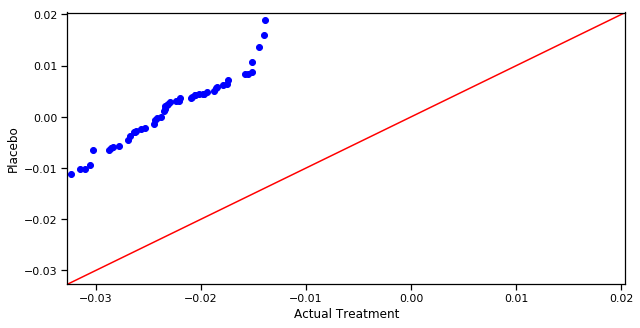

In [18]:
# QQ-Plot to compare empirical distributions. If straight line, no significant difference from placebo treatment.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo', line='45')
pylab.show()

In [19]:
alpha = .05
critical_value = np.sqrt(-np.log(alpha) / 2) * np.sqrt(2 * n_iter/(n_iter * n_iter))

ks_test = scipy.stats.ks_2samp(np.array(placebo_results), np.array(treatment_results))
if ks_test[0] > critical_value and ks_test[1] < alpha:
    print('Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))
else: 
    print('Cannot reject hypothesis that placebo and actual treatment are identical distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.0, p-value: 2.16468817146063e-23)
